In [318]:
import copy

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#计算特征值模块
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# 机器学习模块
from sklearn import model_selection
from sklearn.linear_model import Lasso,LassoCV
from sklearn.metrics import mean_squared_error
# 使用lasso直接进行建模
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler


# 随机森林模块
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#套用网站的九种理化性质计算出来，将序列分成三段，计算相关性，使用lasso进行回归预测，使用随机森林进行预测
#计算靠近的四个端点的理化性质

In [319]:
os.chdir(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek')
df=pd.read_excel('all-peptides-pairs.xlsx',header=0)
#筛选出第一种分类拿来做实验
testdf=df[(df['stick_terminal']=='n_terminal') & (df['communal-modification']=='none') & (df['modification2']=='AMD')]
testdf = testdf[~testdf['sequence'].str.contains('[a-z]')]      #把构象不同的氨基酸筛掉
testdf = testdf[~testdf['sequence'].str.contains('X')]          #把非常规氨基酸筛掉
df_filtered = testdf[testdf['sequence'].str.len() >= 6]          #保证序列长度大于等于4
df_filtered=df_filtered[df_filtered['fold-change']!=0]
# df_filtered.to_excel('df_filtered.xlsx',index=False)

In [320]:
df_filtered

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
0,ALWKTLLKKVLKA,Staphylococcus aureus B38302,n_terminal,none,MIC,uM,none,AMD,3.00,9.00,-1.584963,6.00
1,ALWKTLLKKVLKA,Escherichia coli U16318,n_terminal,none,MIC,uM,none,AMD,6.00,4.50,0.415037,1.50
5,KKLFKKILKYL,Xanthomonas campestris pv. Vesicatoria 2133-2,n_terminal,none,MIC,uM,none,AMD,15.00,4.65,1.689660,10.35
6,KKLFKKILKYL,Pseudomonas syringae pv. syringae EPS 94,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
7,KKLFKKILKYL,Erwinia amylovora PMV 6076,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
...,...,...,...,...,...,...,...,...,...,...,...,...
3104,TQQAFQKFLAAVTSALGKQYH,Aeromonas hydrophila KCTC 2358,n_terminal,none,MEC,ug/ml,none,AMD,125.00,8.80,3.828281,116.20
3105,TQQAFQKFLAAVTSALGKQYH,Streptococcus iniae FP5229,n_terminal,none,MEC,ug/ml,none,AMD,23.00,4.40,2.386058,18.60
3107,TQQAFQKFLAAVTSALGKQYH,Vibrio parahaemolyticus KCCM 41664,n_terminal,none,MEC,ug/ml,none,AMD,1.50,1.70,-0.180572,0.20
3108,TQQAFQKFLAAVTSALGKQYH,Candida albicans KCTC 7965,n_terminal,none,MEC,ug/ml,none,AMD,12.00,6.20,0.952694,5.80


In [321]:
df_filtered[df_filtered['fold-change']!=0]

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
0,ALWKTLLKKVLKA,Staphylococcus aureus B38302,n_terminal,none,MIC,uM,none,AMD,3.00,9.00,-1.584963,6.00
1,ALWKTLLKKVLKA,Escherichia coli U16318,n_terminal,none,MIC,uM,none,AMD,6.00,4.50,0.415037,1.50
5,KKLFKKILKYL,Xanthomonas campestris pv. Vesicatoria 2133-2,n_terminal,none,MIC,uM,none,AMD,15.00,4.65,1.689660,10.35
6,KKLFKKILKYL,Pseudomonas syringae pv. syringae EPS 94,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
7,KKLFKKILKYL,Erwinia amylovora PMV 6076,n_terminal,none,MIC,uM,none,AMD,8.75,4.65,0.912052,4.10
...,...,...,...,...,...,...,...,...,...,...,...,...
3104,TQQAFQKFLAAVTSALGKQYH,Aeromonas hydrophila KCTC 2358,n_terminal,none,MEC,ug/ml,none,AMD,125.00,8.80,3.828281,116.20
3105,TQQAFQKFLAAVTSALGKQYH,Streptococcus iniae FP5229,n_terminal,none,MEC,ug/ml,none,AMD,23.00,4.40,2.386058,18.60
3107,TQQAFQKFLAAVTSALGKQYH,Vibrio parahaemolyticus KCCM 41664,n_terminal,none,MEC,ug/ml,none,AMD,1.50,1.70,-0.180572,0.20
3108,TQQAFQKFLAAVTSALGKQYH,Candida albicans KCTC 7965,n_terminal,none,MEC,ug/ml,none,AMD,12.00,6.20,0.952694,5.80


In [322]:

def Hydrophobicity(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='full':
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
def PI(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='full':
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
def Charge(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='full':
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge

In [323]:
# 计算30个特征
df_attributes=pd.DataFrame()
P_list=['Charge','Hydrophobicity','PI']
types=['0','1','2','-1','-2','-3','full','start','middle','end']
# a_list
for i in types:
    for j in P_list:
        colname='&'.join([i,j])
        if j=='Charge':
            df_attributes[colname]=df_filtered['sequence'].apply(Charge,args=(i,))
        elif j=='Hydrophobicity':
            df_attributes[colname]=df_filtered['sequence'].apply(Hydrophobicity,args=(i,))
        else:
            df_attributes[colname]=df_filtered['sequence'].apply(PI,args=(i,))


In [324]:
#把特征和变量放入一个文件
all_df=copy.deepcopy(df_attributes)
all_df['fold-change']=copy.deepcopy(df_filtered['fold-change'])
all_df

,0&Charge,0&Hydrophobicity,0&PI,1&Charge,1&Hydrophobicity,1&PI,2&Charge,2&Hydrophobicity,2&PI,-1&Charge,...,start&Charge,start&Hydrophobicity,start&PI,middle&Charge,middle&Hydrophobicity,middle&PI,end&Charge,end&Hydrophobicity,end&PI,fold-change
0,-0.204125,1.8,5.570017,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,-0.204125,...,0.794876,0.200000,8.795051,1.396199,-0.180000,10.000545,0.732989,1.475000,8.720010,-1.584963
1,-0.204125,1.8,5.570017,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,-0.204125,...,0.794876,0.200000,8.795051,1.396199,-0.180000,10.000545,0.732989,1.475000,8.720010,0.415037
5,0.759103,-3.9,8.750052,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-1.333333,10.002737,1.758104,0.660000,10.002737,0.758104,-0.466667,8.590880,1.689660
6,0.759103,-3.9,8.750052,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-1.333333,10.002737,1.758104,0.660000,10.002737,0.758104,-0.466667,8.590880,0.912052
7,0.759103,-3.9,8.750052,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-1.333333,10.002737,1.758104,0.660000,10.002737,0.758104,-0.466667,8.590880,0.912052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,3.828281
3105,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,2.386058
3107,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,-0.180572
3108,-0.601803,-0.7,5.184989,-0.239898,-3.5,5.525000,-0.239898,-3.5,5.525000,-0.152724,...,0.397198,-1.500000,8.410110,-0.239898,1.842857,5.525000,0.881051,-0.957143,8.641036,0.952694


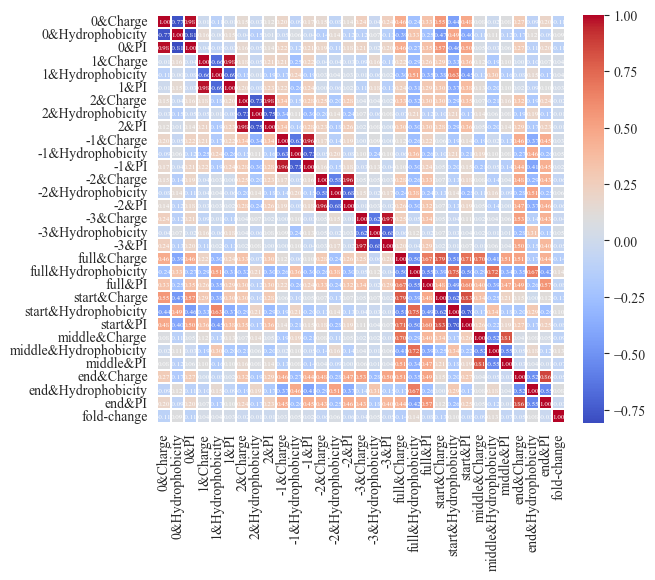

In [332]:
# 计算相关性并绘制相关性热图
corr_data=all_df.corr(method='pearson')
#绘制相关性热图
plt.figure(figsize=(8,6), facecolor='w') # 底色white
cor_map = sns.heatmap(corr_data, square=True, annot=True, fmt='.2f',
                 linewidth=0.1, cmap='coolwarm',linecolor='white', cbar=True,
                 annot_kws={'size':5,'weight':'normal','color':'white'},
                 cbar_kws={'fraction':0.046, 'pad':0.03})
plt.rcParams['font.sans-serif']= ['Times New Roman']    # 设置字体
# plt.xticks(rotation=90,fontsize=8)  # x轴的标签旋转90度
# plt.yticks(fontsize=8)
plt.subplots_adjust(bottom=0.2,left=0.05,right=0.8)
plt.savefig("AMD-heatmap-nozerosample.png", dpi=1300)

In [326]:
# lasso模型回归
# 读取数据
lasso_model = copy.deepcopy(all_df)  #原始文件改变需要调这里，切记这个原始文件是所有特征和fold-change合在一起了

# 分离特征和因变量
X_lasso = lasso_model.drop('fold-change', axis=1)
y_lasso = lasso_model['fold-change']

# 数据标准化
# scaler = StandardScaler()
# X_lasso = scaler.fit_transform(X_lasso)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.1, random_state=42)

# Lasso模型训练
lasso = Lasso()
param_grid = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]}
grid_search = GridSearchCV(lasso, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 最佳alpha值
best_alpha = grid_search.best_params_['alpha']
# best_params = grid_search.best_params_
# lasso = grid_search.best_estimator_

# 选择重要特征
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index=all_df.columns[:-1])  #原始文件改变需要调这里
important_features = coef.abs().nlargest(5).index.tolist()

# 模型评估
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R2:', r2)

D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+03, tolerance: 3.568e-01
  model = cd_fast.enet_coordinate_descent(
D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+03, tolerance: 3.590e-01
  model = cd_fast.enet_coordinate_descent(
D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e+03, tolerance: 3.258e-01
  model = cd_fast

MSE: 3.6061725042376382
R2: 0.06050376865153573


In [327]:
# 输出所有特征的系数
# coef=coef.abs().sort_values(ascending=False)
sorted_index = coef.abs().argsort()[::-1]
sorted_s = coef.iloc[sorted_index]
# sorted_s.to_excel(r'AMD-coef1.xlsx')   #输出没有去0样本
# sorted_s.to_excel(r'AMD-coef2.xlsx')   #输出具有0的样本
# sorted_s
# best_alpha
# best_params

In [328]:
# lasso模型后续分析
# 创建一个分析氨基酸分布的图表（lasso分析中3和-3位置的氨基酸净电荷贡献较大，然后统计一下这两个位点的氨基酸分布
# amino1=pd.DataFrame()
# amino1['position3']=df_filtered['sequence'].apply(lambda x: x[2])
# amino1['position-3']=df_filtered['sequence'].apply(lambda x: x[-3])

In [329]:
# 根据lasso提取系数较高的特征和变量重建一个文档
# newcolumns=['start&Charge','middle&Charge','start&Hydrophobicity','middle&Hydrophobicity','end&Charge','3&PI','full&Hydrophobicity','full&Charge','fold-change']
# new_all_data=all_df[newcolumns]
# new_all_data

In [330]:
# 随机森林模型
# 将y变为离散型
model_data=copy.deepcopy(all_df)
model_data['sig']=0
model_data.loc[model_data['fold-change']>0,'sig']=1
model_data.loc[model_data['fold-change']<0,'sig']=-1

# 拆分自变量和变量
X=copy.deepcopy(model_data.drop('fold-change',axis=1))
X=X.drop('sig',axis=1)
y=copy.deepcopy(model_data['sig'])



# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# 构建随机森林模型
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=123)

# 在训练集上训练模型
rfc.fit(X_train, y_train)

# 在测试集上测试模型性能
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# 在训练集上训练模型
rfc.fit(X_train, y_train)

# 在测试集上测试模型性能
y_pred = rfc.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# 输出模型评估结果
# print("Accuracy:", accuracy)

# 输出评价参数
print(classification_report(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# print(classification_report((y_train,)))


              precision    recall  f1-score   support

          -1       0.67      0.63      0.65        38
           1       0.84      0.86      0.85        83

    accuracy                           0.79       121
   macro avg       0.75      0.74      0.75       121
weighted avg       0.78      0.79      0.78       121



In [331]:
# 提取特征重要性
importances = rfc.feature_importances_
indices = importances.argsort()[::-1]
for i in indices:
    print(f"{X.columns[i]}: {importances[i]}")

full&Hydrophobicity: 0.09831060899673123
start&Hydrophobicity: 0.07769260325023727
full&Charge: 0.0757118956690078
middle&Hydrophobicity: 0.06171054886034216
end&Hydrophobicity: 0.049403889696038934
end&Charge: 0.04437814578656469
middle&Charge: 0.04231896139854406
1&Hydrophobicity: 0.03999152299953438
full&PI: 0.03721326549505436
middle&PI: 0.03528257928928175
end&PI: 0.03306709853321245
start&PI: 0.032257157242042755
start&Charge: 0.03160561179835575
-1&Hydrophobicity: 0.028917384637211753
0&Hydrophobicity: 0.027480447596273192
2&Hydrophobicity: 0.02614896454969173
-1&Charge: 0.025653500558297217
-3&Hydrophobicity: 0.025088909156323665
-1&PI: 0.025037884114939613
-2&Hydrophobicity: 0.022305057662200162
-2&PI: 0.02119856992578604
-3&PI: 0.01829039936707539
-2&Charge: 0.017696747666550366
2&Charge: 0.01752495582465095
2&PI: 0.0157365224781096
-3&Charge: 0.015273495439113893
1&PI: 0.014990715856848622
0&Charge: 0.013702226457084587
0&PI: 0.013563450731130543
1&Charge: 0.0124468789637648